This notebook is about single gene spatial statistics, it allows to characterize, one gene at a time the distribution of 
rna's in the cells. 


23/04/25     Jacques Bourg @ Florian Muller lab. Institut Pasteur.

<img src="./HOX_pipeline.png" alt="LNP pipeline" width="1200" height="477">

In [1]:
import sys
import os
import numpy as np
import napari
from skimage import io
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

base_dir = Path("../../src").resolve()
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "utils"))
sys.path.append(str(base_dir / "segmentation"))
sys.path.append(str(base_dir / "synthesis"))

from segmentation.refine_seg import Segmentation
from synthesis.synthesize import Synthesis
from utils.plots import Plots
from utils.parameters_tracking import Parameter_tracking as Track
from utils.file_handling import FileProcessor

sg  = Segmentation()
pts = Plots()
tk  = Track()
fp  = FileProcessor()
st  = Synthesis()

In [3]:
var = str(Path('../Analysis'))
batch_folders = os.listdir(var)
dropdown = widgets.Dropdown(options=batch_folders, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('2024-11-18_Helena-Ho…

In [4]:
n         = np.where(np.array(batch_folders) == dropdown.value)[0][0]
file_path = str(Path(var) / Path(batch_folders[n]) / Path(batch_folders[n] +'.json'))
constants = tk.load_json(file_path)
batch_name= constants['BATCH_NAME']; print(batch_name)

2024-11-18_Helena-Hox-9-10_spinning_2


In [5]:
modalities = constants['MODALITIES']
dropdown2 = widgets.Dropdown(options=modalities, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown2)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('EXPERIMENT', 'CONTRO…

In [6]:
n2       = np.where(np.array(modalities) == dropdown2.value)[0][0] 
modality = modalities[n2]; print(modality)

EXPERIMENT


Select channels used to detect dots (corresponding to a particular gene or simply called FISH). DAPI do not makes sense.

In [7]:
channels_cell = constants['CHANNELS'] #  (could also be FISH_0, FISH_1, ... or even different genes names), DAPI doesn't make sense
dropdown3 = widgets.Dropdown(options=channels_cell, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown3)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'HOXC8', 'HOX…

In [30]:
n3     = np.where(np.array(channels_cell) == dropdown3.value)[0][0]
chan_f = channels_cell[n3]; print(chan_f)
chan_n = constants["CHANNELS_NUM"][n3]
color  = constants["COLORS"][n3]; print(color)               

HOXA10
red


Select nuclei

In [31]:
structs   = constants['STRUCTURES'] 
dropdown6 = widgets.Dropdown(options=structs, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown6)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('NUCLEI', 'CELL'), va…

In [32]:
n6   = np.where(np.array(structs) == dropdown6.value)[0][0]
struc_nuc = structs[n6]; print(struc_nuc)

NUCLEI


Select the channel used to detect the nuclei

In [33]:
channels_nuc = constants['CHANNELS'] #   choose DAPI, FISH doesn't make sense
dropdown_n = widgets.Dropdown(options=channels_nuc, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown_n)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'HOXC8', 'HOX…

In [34]:
n_nuc    = np.where(np.array(channels_nuc) == dropdown_n.value)[0][0]
chan_nuc = channels_nuc[n_nuc]; print(chan_nuc)

DAPI


Select the cell

In [35]:
structs   = constants['STRUCTURES'] 
dropdown7 = widgets.Dropdown(options=structs, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown7)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('NUCLEI', 'CELL'), va…

In [36]:
n7         = np.where(np.array(structs) == dropdown7.value)[0][0]
struc_cell = structs[n7]; print(struc_cell)

CELL


In [37]:
detection_methods = ['UFISH','BIGFISH']
dropdown8         = widgets.Dropdown(options=detection_methods, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown8)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('UFISH', 'BIGFISH'), …

In [38]:
n8     = np.where(np.array(detection_methods) == dropdown8.value)[0][0]
meth   = detection_methods[n8]; print(meth)

UFISH


#### A
batch processing, to do the figures once the next cells were executed, jump directly to B.

In [39]:
mask_nuc_path        = constants[f'MASK_{modality}_DAPI_{struc_nuc}_CLEANED_LIST_PATH']         
mask_cell_path       = constants[f'MASK_{modality}_DAPI_{struc_cell}_CLEANED_LIST_PATH']   

dict_mask_nuc_m      = fp.load_masks_distributed_files(mask_nuc_path)                                
dict_mask_cells_m    = fp.load_masks_distributed_files(mask_cell_path)    

file_add_mask_stats  = constants[f"MASK_{modality}_{struc_cell}_STATS_{meth}_{chan_f}_LIST_PATH"]
dic_masks_cell_stats = fp.load_pd_distributed_files(file_add_mask_stats)

dots_path            = constants[f'DOTS_{meth}_{modality}_{chan_f}_PATH']
dict_dots            = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

batch_fish_mip       = constants[f'BATCH_{modality}_DAPI_NUCLEI_MIP']

In [40]:
im_dim = 3 if 'Z' in dict_dots[list(dict_dots.keys())[0]] else 2

dic_count_spots       = {}
dic_spots_in_cells    = {}
dic_spots_in_nuclei   = {}
   
for ind, file_base_name in enumerate(list(dict_mask_nuc_m.keys())):
    mask_cell     = dict_mask_cells_m[file_base_name]
    mask_nuc      = dict_mask_nuc_m[file_base_name]
    df_spots      = dict_dots[file_base_name]
    image_2D      = io.imread(batch_fish_mip[ind])

    df_stat_cells             = dic_masks_cell_stats[file_base_name]
    df_stat_cells, df_spots   = sg.count_spots_in_masks_df(mask_cell, df_stat_cells, df_spots)
    df_stat_cells, df_spots   = sg.spots_in_nuclei_df(mask_nuc, df_stat_cells, df_spots)
    df_stat_cells             = st.spatial_statistics(mask_cell, mask_nuc, df_stat_cells, df_spots, image_2D)

    dict_dots[file_base_name] = df_spots
    dic_masks_cell_stats[file_base_name] = df_stat_cells

fp.save_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'], dict_dots, im_dim)
fp.save_masks_stats_distributed_files_modif(file_add_mask_stats,  dic_masks_cell_stats)

/home/jacques/miniconda3/envs/base_env_apifish/lib/python3.9/site-packages/apifish/classification/input_preparation.py:138: RuntimeWarning: invalid value encountered in divide
  distance_nuc_normalized = distance_nuc / distance_nuc.max()


#### B
    Figures

In [41]:
file_add_mask_stats  = constants[f"MASK_{modality}_{struc_cell}_STATS_{meth}_{chan_f}_LIST_PATH"]
dic_masks_cell_stats = fp.load_pd_distributed_files(file_add_mask_stats)

dots_path            = constants[f'DOTS_{meth}_{modality}_{chan_f}_PATH']
dict_dots            = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

#### Manual step      (WARNING: Manual input required)
Organize your batch in rows and columns: rows can be conditions, and columns time or rows can be repetitions and columns conditions
store as (line, column) for each element of the batch. Put None in case you don't want to display it. 
For instance if your batch files is ['file_control0', 'file_control1', 'file_control2', 'file_rep1_c1', 'file_rep2_c1', 'file_rep1_c2', 'file_rep2_c2'] and you want to organize your 
display as:

|          | Concentration 1 | Concentration 2 |
|----------|----------|----------|
| **Rep 1**| R1, C1   | R1, C2   | 
| **Rep 2**| R2, C1   | R2, C2   |


Then, insert the coordinates, in the following way,  do for a batch of experiments like:

batch      = [`Exp to discard`, `Exp to discard`, `Exp to discard`, `R1,C1`, `R2,C1`,`R1,C2`,  `R2,C2` ]

batch_plot = [`None` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,  `None`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,  `None `&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;,`(0,0) `,`(1,0) `,`(0,1) `,`(1,1)`]

In [42]:
# batch_plot = [None, None, None, (0,0), (1,0), (2,0), (0,1), (1,1), (0,2), (1,2)] # None to omit a plot.

batch_fish = constants[f'BATCH_{modality}_{chan_f}']

leg_x = ['6h', '24h', '48h']
leg_y = ['NT', 'GDF', 'FGF-GDF']
name  = f'{modality}_{chan_f}_{meth}'

lines = len(leg_y)
cols  = len(leg_x)

print([Path(el).stem for el in batch_fish])
batch_plot         = [(0,0), (0,1), (0,2), (1,0), (1, 1), (1,2), (2,0), (2,1), (2,2)]             # batch_pot has the same dimension as batch.
batch_subselection = [1 if el is not None else 0 for el in batch_plot]          # given the choice made before, we will only plot those files.

['HM40-J3DIFF-NT6h-HOXA10-620_HOXC8-520-1002-1_HOXA10', 'HM40-J3DIFF-NT24h-HOXA10-620_HOXC8-520-1005-1_HOXA10', 'HM40-J3DIFF-NT48h-HOXA10-620_HOXC8-520-1008-1_HOXA10', 'HM40-J3DIFF-GDF6h-HOXA10-620_HOXC8-522-1_HOXA10', 'HM40-J3DIFF-GDF24h-HOXA10-620_HOXC8-525-1_HOXA10', 'HM40-J3DIFF-GDF48h-HOXA10-620_HOXC8-528-1_HOXA10', 'HM40-J3DIFF-FGFGDF6h-HOXA10-620_HOXC8-531-1_HOXA10', 'HM40-J3DIFF-FGFGDF24h-HOXA10-620_HOXC8-534-1_HOXA10', 'HM40-J3DIFF-FGFGDF48h-HOXA10-620_HOXC8-537-1_HOXA10']


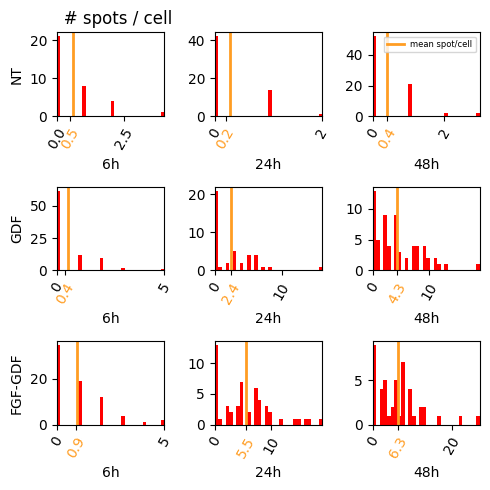

In [43]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for ind, file_name in enumerate(batch_fish):
    if batch_subselection[ind]:
        file_base    = '_'.join(Path(file_name).stem.split('_')[:-1])
        ind_l, ind_c = batch_plot[ind] 
        pts.plot_hist_num_dots_nuclei(dic_masks_cell_stats[file_base]['counts'].to_numpy(), fig, axes, ind_l, ind_c,
                                    leg_x, leg_y, title='', color=color, bins= 30,
                                    struct='cell', shape=(3,3))
    
    
fig.tight_layout()
fig.savefig(Path(f"../Analysis/{batch_name}/Figures/{batch_name}_num_spots_per_cell_{name}.png"), bbox_inches="tight")   

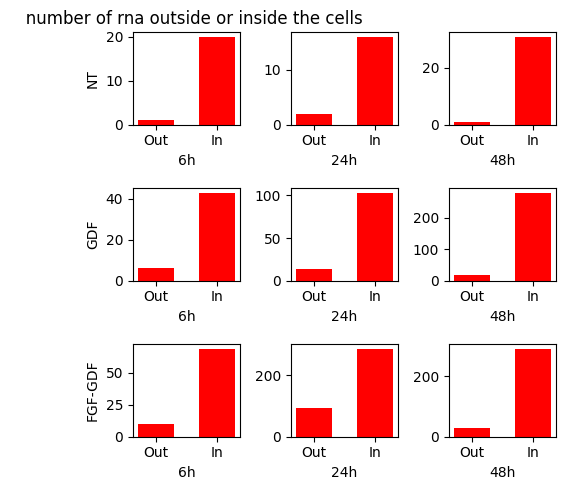

In [44]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for ind, file_name in enumerate(batch_fish):
    if batch_subselection[ind]:
        file_base    = '_'.join(Path(file_name).stem.split('_')[:-1])
        ind_l, ind_c = batch_plot[ind]
        temp = dict_dots[file_base]['in_cell'].to_numpy()
        temp = temp[~np.isnan(temp)]
        pts.plot_subcellular_localization(temp, fig, axes, 
                                          ind_l, ind_c, leg_x, leg_y, color= color, title='',
                                          struct = '   number of rna outside or inside the cells' ,shape=(3,3))
    
fig.tight_layout()
fig.savefig(Path(f"../Analysis/{batch_name}/Figures/{batch_name}_spots_in_cells_{name}.png"), bbox_inches="tight")   

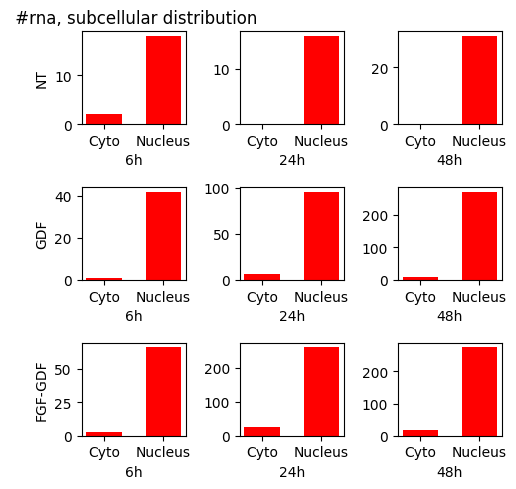

In [45]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for ind, file_name in enumerate(batch_fish):
    if batch_subselection[ind]:
        file_base    = '_'.join(Path(file_name).stem.split('_')[:-1])
        ind_l, ind_c = batch_plot[ind]
        temp = dict_dots[file_base]['in_nuclei'].to_numpy()
        temp = temp[~np.isnan(temp)]
        pts.plot_subcellular_localization(temp, fig, axes, 
                                          ind_l, ind_c, leg_x, leg_y, color= color, title='',
                                          struct = ' #rna, subcellular distribution',shape=(3,3))    

   
fig.tight_layout()
fig.savefig(Path(f"../Analysis/{batch_name}/Figures/{batch_name}_subcellular_dist_{name}.png"), bbox_inches="tight")  

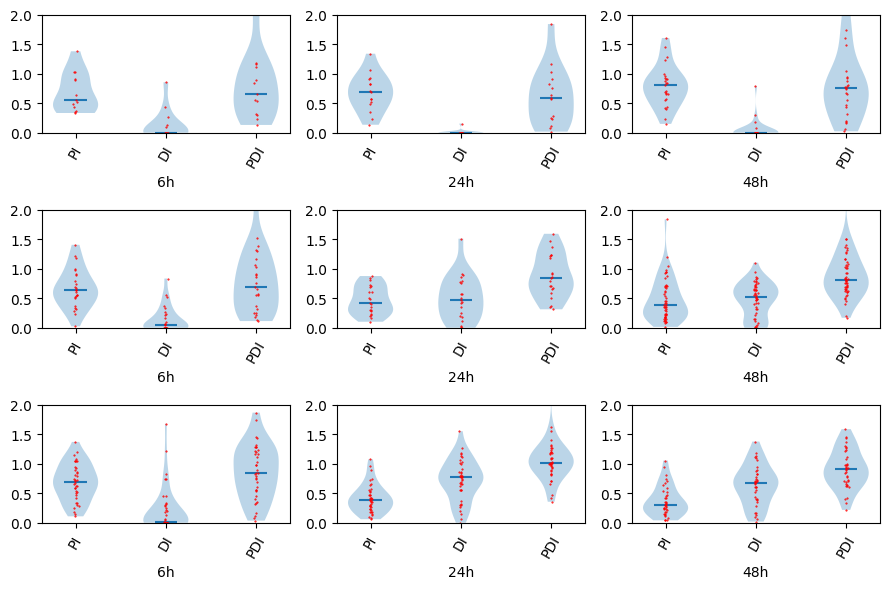

In [46]:
names_short = ['PI', 'DI', 'PDI']
y_max = 2

fig_ind, ax = plt.subplots(3,3,figsize=(9,6))
for ind, file_name in enumerate(batch_fish):
    if batch_subselection[ind]:
        file_base    = '_'.join(Path(file_name).stem.split('_')[:-1])
        ind_l, ind_c = batch_plot[ind]

        temp = dic_masks_cell_stats[file_base]['pol_ind'].to_numpy()
        pi   = temp[~ np.isnan(temp)]
        temp = dic_masks_cell_stats[file_base]['disp_ind'].to_numpy()
        di   = temp[~ np.isnan(temp)]
        temp = dic_masks_cell_stats[file_base]['per_dist_ind'].to_numpy()
        pdi  = temp[~ np.isnan(temp)]
        
        indexes = []
        indexes.append(pi)
        indexes.append(di)
        indexes.append(pdi)

        violinplot = ax[ind_l,ind_c].violinplot(indexes, showmedians=True, showextrema=False)

        for i, group in enumerate(indexes):
            x_coords = np.ones_like(group) * (i + 1) + np.random.normal(0, 0.01, size=len(group))
            for ind in range(len(x_coords)):
                ax[ind_l,ind_c].plot(x_coords[ind], group[ind], color=color, marker='.', markersize = 1)

            ax[ind_l,ind_c].set_xticks(np.arange(1, len(indexes)+1 ))
            ax[ind_l,ind_c].set_xticklabels(names_short, rotation=60)
            ax[ind_l,ind_c].set_ylim([0, y_max])
            ax[ind_l,ind_c].set_xlabel(leg_x[ind_c])

    
fig_ind.tight_layout()
fig_ind.savefig(Path(f"../Analysis/{batch_name}/Figures/{batch_name}_spatial_dist_indexes_{name}.png"), bbox_inches="tight")

#### Visual QC

In [47]:
mask_nuc_path     = constants[f'MASK_{modality}_DAPI_{struc_nuc}_CLEANED_LIST_PATH']         
mask_cell_path    = constants[f'MASK_{modality}_DAPI_{struc_cell}_CLEANED_LIST_PATH']

dict_mask_nuc_m   = fp.load_masks_distributed_files(mask_nuc_path)
dict_mask_cells_m = fp.load_masks_distributed_files(mask_cell_path)

dots_path         = constants[f'DOTS_{meth}_{modality}_{chan_f}_PATH']
dict_dots         = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])

SELECT DAPI, to get the MIP

In [48]:
channels_cell = constants['CHANNELS'] 
dropdown10    = widgets.Dropdown(options=channels_cell, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown10)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('DAPI', 'HOXC8', 'HOX…

In [49]:
n10            = np.where(np.array(channels_cell) == dropdown10.value)[0][0]
chan_d         = channels_cell[n10]; print(chan_d)
batch_dapi_mip = constants[f'BATCH_{modality}_{chan_d}_{struc_nuc}_MIP']
batch_fish     = constants[f'BATCH_{modality}_{chan_f}']

DAPI


In [50]:
viewer_sl  = napari.Viewer(title="Subcellular location")
counter    = 0
for ind, file_name in enumerate(batch_fish):
    if batch_subselection[ind]:
        file_base    = '_'.join(Path(file_name).stem.split('_')[:-1])
    
        im_nuc       = io.imread(batch_dapi_mip[ind])
        
        viewer_sl.add_image(im_nuc, rgb=False, name=f"DAPI {file_base}")
        cell_layer = viewer_sl.add_labels(dict_mask_cells_m[file_base], name=f"Cells {file_base}", opacity=.2, blending='translucent')
        nuc_layer  = viewer_sl.add_labels(dict_mask_nuc_m[file_base], name=f"Nuclei {file_base}", opacity=.4, blending='translucent')
        
        spots_2d  = dict_dots[file_base].loc[dict_dots[file_base]['in_mask'], ['Y', 'X']].to_numpy()
        
        viewer_sl.add_points(spots_2d, name=f"Spots {file_base}", size=12, face_color=color);

        if counter != 0:
            viewer_sl.layers[f"DAPI {file_base}"].visible    = False
            viewer_sl.layers[f"Cells {file_base}"].visible   = False
            viewer_sl.layers[f"Nuclei {file_base}"].visible  = False
            viewer_sl.layers[f"Spots {file_base}"].visible   = False 
        counter +=1